# 3d elastostatics 

Imports:

In [1]:
import os 
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
import numpy as np

import jax
import jax.numpy as jnp
from jax.example_libraries import stax, optimizers
import matplotlib.pyplot as plt
import pinns 
import datetime
import jax.scipy.optimize
import jax.flatten_util
import scipy
import scipy.optimize

Convince JAX to use `float64` and create the random key.

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)
rnd_key = jax.random.PRNGKey(1234)

### Geometry construction

The domain consists of 4 subdomains parametrized using NURBS.

In [3]:
def create_geometry(key, scale = 1):
    R = 2
    r = 1
    Rp = 2
    d = 0.5
    
    knots = np.array( [ [[[r,0,0], [r,0,r], [0,0,r]], [[r,d,0], [r,d,r], [0,d,r]]], [[[R,0,0], [R,0,R], [0,0,R]], [[R,d,0], [R,d,R], [0,d,R]]] ])
    weights = np.ones(knots.shape[:3])
    weights[:,:,1] = 1/np.sqrt(2)
    
    basis1 = pinns.bspline.BSplineBasisJAX(np.array([-1,1]),1)
    basis2 = pinns.bspline.BSplineBasisJAX(np.array([-1,1]),1)
    basis3 = pinns.bspline.BSplineBasisJAX(np.array([-1,1]),2)

    geom1 = pinns.geometry.PatchNURBSParam([basis1, basis2, basis3], knots, weights, 0, 3, key)
    
    knots = np.array( [[[[0,0,r],[-(R-r),0,r]], [[0,d,r],[-(R-r),d,r]]], [[[0,0,R],[-(R-r),0,R]], [[0,d,R],[-(R-r),d,R]]]] )
    weights = np.ones(knots.shape[:3])
    
    basis1 = pinns.bspline.BSplineBasisJAX(np.array([-1,1]),1)
    basis2 = pinns.bspline.BSplineBasisJAX(np.array([-1,1]),1)
    basis3 = pinns.bspline.BSplineBasisJAX(np.array([-1,1]),1)

    geom2 = pinns.geometry.PatchNURBSParam([basis1, basis2, basis3], knots, weights, 0, 3, key)
    
    knots = np.array( [[[[r+Rp,-R,r], [-(R-r),-R,r], [-(R-r),0,r]], [[r+Rp,-r,r], [0,-r,r], [0,0,r]]], [[[r+Rp,-R,R], [-(R-r),-R,R], [-(R-r),0,R]], [[r+Rp,-r,R], [0,-r,R], [0,0,R]]]] )
    knots = np.transpose(knots,[0,2,1,3])
    knots = knots[:,:,::-1,:]
    weights = np.ones(knots.shape[:3])
    weights[:,1,:] = 1/np.sqrt(2)
    
    basis1 = pinns.bspline.BSplineBasisJAX(np.array([-1,1]),1)
    basis3 = pinns.bspline.BSplineBasisJAX(np.array([-1,1]),1)
    basis2 = pinns.bspline.BSplineBasisJAX(np.array([-1,1]),2)

    geom3 = pinns.geometry.PatchNURBSParam([basis1, basis2, basis3], knots, weights, 0, 3, key)
    
    
    knots = np.array( [[[[r+Rp,R+d,r], [-(R-r),R+d,r], [-(R-r),d,r]], [[r+Rp,r+d,r], [0,r+d,r], [0,d,r]]], [[[r+Rp,R+d,R], [-(R-r),R+d,R], [-(R-r),d,R]], [[r+Rp,r+d,R], [0,r+d,R], [0,d,R]]]] )
    knots = np.transpose(knots,[0,2,1,3])
    knots = knots[:,::-1,...]
    knots = knots[:,:,::-1,:]
    weights = np.ones(knots.shape[:3])
    weights[:,1,:] = 1/np.sqrt(2)
    
    
    basis1 = pinns.bspline.BSplineBasisJAX(np.array([-1,1]),1)
    basis2 = pinns.bspline.BSplineBasisJAX(np.array([-1,1]),2)
    basis3 = pinns.bspline.BSplineBasisJAX(np.array([-1,1]),1)

    geom4 = pinns.geometry.PatchNURBSParam([basis1, basis2, basis3], knots, weights, 0, 3, key)
    
    return  geom1, geom2, geom3, geom4

Display the geometry. First, some random points are plotted and then the axis of the reference domains are shown in the physical domain.

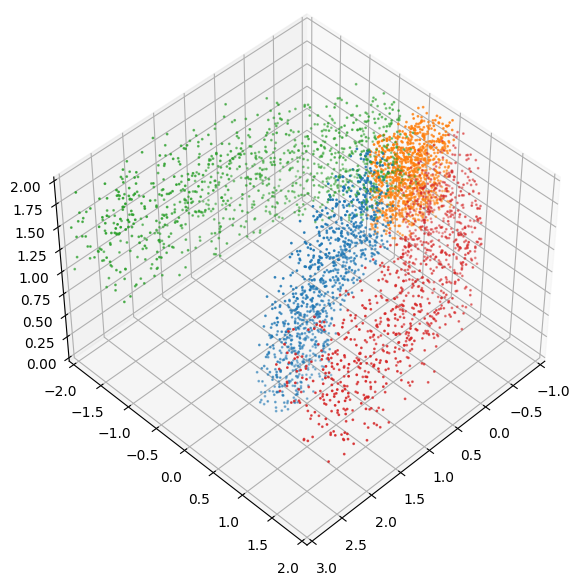

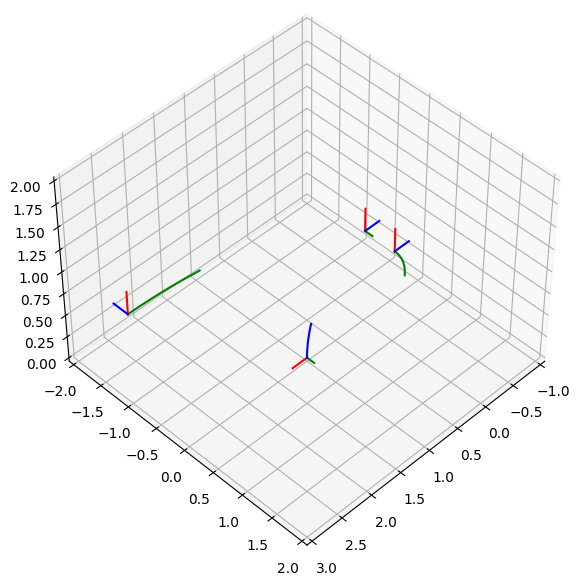

In [4]:
geom1, geom2, geom3, geom4 = create_geometry(rnd_key)
geoms = [geom1, geom2, geom3, geom4]

pts1,_ = geom1.importance_sampling(1000)
pts2,_ = geom2.importance_sampling(1000)
pts3,_ = geom3.importance_sampling(1000)
pts4,_ = geom4.importance_sampling(1000)

plt.figure(figsize=(7,7))
ax = plt.axes(projection ="3d")
ax.scatter3D(pts1[:,0], pts1[:,1], pts1[:,2], s = 1)
ax.scatter3D(pts2[:,0], pts2[:,1], pts2[:,2], s = 1)
ax.scatter3D(pts3[:,0], pts3[:,1], pts3[:,2], s = 1)
ax.scatter3D(pts4[:,0], pts4[:,1], pts4[:,2], s = 1)
ax.axes.set_xlim3d(-1,3)
ax.axes.set_ylim3d(-2,2)
ax.axes.set_zlim3d(0,2)
ax.view_init(45,45)

yspace= np.linspace(-1,-0.5,100)

plt.figure(figsize=(7,7))
ax = plt.axes(projection ="3d")
for g in geoms:
    ys = np.concatenate((yspace[...,None], yspace[...,None]*0-1, yspace[...,None]*0-1),-1)
    Xs = g(ys)
    ax.plot(Xs[:,0], Xs[:,1], Xs[:,2],'red')
    
    ys = np.concatenate((yspace[...,None]*0-1, yspace[...,None], yspace[...,None]*0-1),-1)
    Xs = g(ys)
    ax.plot(Xs[:,0], Xs[:,1], Xs[:,2],'green')
    
    ys = np.concatenate((yspace[...,None]*0-1, yspace[...,None]*0-1, yspace[...,None]),-1)
    Xs = g(ys)
    ax.plot(Xs[:,0], Xs[:,1], Xs[:,2],'blue')
    
ax.axes.set_xlim3d(-1,3)
ax.axes.set_ylim3d(-2,2)
ax.axes.set_zlim3d(0,2)
ax.view_init(45,45)


### Construct the neural network model

For every of the 4 subdomain, a neural network is used. Moreover, for the 3 interfaces, additional neural networks are defined.

In [5]:
def interface_function3d(nd, endpositive, endzero, nn, alpha = 2.0):

    faux = lambda x: ((x-endzero)**alpha/(endpositive-endzero)**alpha)
    if nd == 0:
        fret = lambda ws, x: (nn(ws, jnp.concatenate((x[...,1][...,None],x[...,2][...,None]),-1))*faux(x[...,0])[...,None])
    elif nd==1:
        fret = lambda ws, x: (nn(ws, jnp.concatenate((x[...,0][...,None],x[...,2][...,None]),-1))*faux(x[...,1])[...,None])
    elif nd==2:
        fret = lambda ws, x: (nn(ws, jnp.concatenate((x[...,0][...,None],x[...,1][...,None]),-1))*faux(x[...,2])[...,None])
    else: 
        raise Exception("nd must be 0,1 or 2.")
    return fret

def interface_function1d(dembedding: int, dim: int, zeros: list[int], ones: list[int], nn: callable, alpha: float = 2.0) -> callable:

    faux = lambda y,one,zero: ((y-zero)**alpha/(one-zero)**alpha)

    if dembedding==3:
        dims = list(set(range(dembedding)) - {dim})
        fret = lambda ws, x, *params: (nn(ws, x[...,dim][...,None], *params)*faux(x[...,dims[0]],ones[0],zeros[0])[...,None]*faux(x[...,dims[1]],ones[1],zeros[1])[...,None])

    return fret


def jump_function3d(nd, pos_y, nn):

    faux = lambda x: jnp.exp(-4.0*jnp.abs(x-pos_y))
    if nd == 1:
        fret = lambda ws, x: (nn(ws, x[...,1][...,None]).flatten()*faux(x[...,0]))[...,None]
    else:
        fret = lambda ws, x: (nn(ws, x[...,0][...,None]).flatten()*faux(x[...,1]))[...,None]
    return fret

def monom(x: jax.numpy.array, d: int, bound: float, deg: float = 1.0, out_dims: int = 1):
    return jnp.tile(((x[...,d]-bound)**deg)[...,None],out_dims)

# def ExpHat(hidden_size, out_dim, W_init=glorot_normal(), b_init=normal()):
#   """Layer constructor function for a dense (fully-connected) layer."""
#   def init_fun(rng, input_shape):
#     output_shape = input_shape[:-1] + (out_dim,)
#     k1, k2 = random.split(rng)
#     W, b = W_init(k1, (input_shape[-1], out_dim)), b_init(k2, (out_dim,))
#     return output_shape, (W, b)
#   def apply_fun(params, inputs, **kwargs):
#     b, b = params
#     return jnp.dot(inputs, W) + b
#   return init_fun, apply_fun
def ExpHat(x, scale = 0.1):
    return jnp.exp(-jnp.abs(x)/scale)

class Model(pinns.PINN):
    def __init__(self, rand_key):
        super().__init__()
        self.key = rand_key

        nl = 16
        acti =  stax.elementwise(lambda x: jax.nn.leaky_relu(x)**2)

        w_init = jax.nn.initializers.normal()
        
        block_first = stax.serial(stax.FanOut(2),stax.parallel(stax.serial(stax.Dense(nl,W_init = w_init), acti, stax.Dense(nl,W_init = w_init), acti),stax.Dense(nl,W_init = w_init)),stax.FanInSum)
        block = stax.serial(stax.FanOut(2),stax.parallel(stax.serial(stax.Dense(nl,W_init = w_init), acti, stax.Dense(nl,W_init = w_init), acti),stax.Dense(nl,W_init = w_init)),stax.FanInSum)
        
        self.add_neural_network('u1',stax.serial(block_first,block,block, block, stax.Dense(3)),(-1,3)) # leg
        self.add_neural_network('u2',stax.serial(block_first,block,block, block, stax.Dense(3)),(-1,3)) # split
        self.add_neural_network('u3',stax.serial(block_first,block,block, block, stax.Dense(3)),(-1,3)) # arm left
        self.add_neural_network('u4',stax.serial(block_first,block,block, block, stax.Dense(3)),(-1,3)) # arm right
        self.add_neural_network('u12',stax.serial(block_first,block,block, block, stax.Dense(3)),(-1,2)) 
        self.add_neural_network('u23',stax.serial(block_first,block,block, block, stax.Dense(3)),(-1,2)) 
        self.add_neural_network('u24',stax.serial(block_first,block,block, block, stax.Dense(3)),(-1,2)) 
        
        self.interface12 = interface_function3d(2, 1.0, -1.0, self.neural_networks['u12'])
        self.interface21 = interface_function3d(2, -1.0, 1.0, self.neural_networks['u12'])
        self.interface123 = interface_function1d(3, 0, [-1,1],[1,-1], lambda ws, y, *extra: self.neural_networks['u12'](ws, jnp.concatenate((y,y*0-1),-1), *extra))
        self.interface124 = interface_function1d(3, 0, [1,1],[-1,-1], lambda ws, y, *extra: self.neural_networks['u12'](ws, jnp.concatenate((y,y*0+1),-1), *extra))

        self.interface23 = interface_function3d(1, -1.0, 1.0, self.neural_networks['u23'])
        self.interface32 = interface_function3d(1, 1.0, -1.0, self.neural_networks['u23'])
        self.interface231 = interface_function1d(3, 0, [1,-1],[-1,1], lambda ws, y, *extra: self.neural_networks['u23'](ws, jnp.concatenate((y,y*0-1),-1), *extra))

        self.interface24 = interface_function3d(1, 1.0, -1.0, self.neural_networks['u24'])
        self.interface42 = interface_function3d(1, -1.0, 1.0, self.neural_networks['u24'])
        self.interface241 = interface_function1d(3, 0, [-1,-1],[1,1], lambda ws, y, *extra: self.neural_networks['u24'](ws, jnp.concatenate((y,y*0-1),-1), *extra))

        self.points = self.get_points_MC(10000, self.key)
        
        E = 0.02e5
        nu = 0.1
        self.E = E
        self.nu = nu
        
        self.lamda = E*nu/(1+nu)/(1-2*nu)
        self.mu = E/2/(1+nu)
        
        rho = 0.1/2*8
        g = 9.81
        self.rho = rho
        
        self.f = np.array([0,0,-g*rho])
        
        
    def get_points_MC(self, N, key):        

        points = {}


        ys = jax.random.uniform(key ,(N,3))*2-1
        Weights = jnp.ones((N,))*8/ys.shape[0]
        # ys = np.array(jax.random.uniform(self.key, (N,2)))*2-1
        # Weights = jnp.ones((N,))*4/ys.shape[0]


        points['ys1'] = ys
        points['ws1'] = Weights
        points['omega1'], points['G1'], points['K1'] = geom1.GetMetricTensors(ys)
       
        points['ys2'] = ys
        points['ws2'] = Weights
        points['omega2'], points['G2'], points['K2'] = geom2.GetMetricTensors(ys)
        
        points['ys3'] = ys
        points['ws3'] = Weights
        points['omega3'], points['G3'], points['K3'] = geom3.GetMetricTensors(ys)
        
        points['ys4'] = ys
        points['ws4'] = Weights
        points['omega4'], points['G4'], points['K4'] = geom4.GetMetricTensors(ys)

        return points


    def solution1(self, ws, y):
        # iron
        u = self.neural_networks['u1'](ws['u1'],y)
        v = monom(y,2,-1,out_dims = 3)*monom(y,2,1, out_dims = 3)
        w = self.interface12(ws['u12'],y)+self.interface231(ws['u23'], y)+self.interface241(ws['u24'], y)
        
        return u*v+w

    def solution2(self, ws, y):
        # iron
        u = self.neural_networks['u2'](ws['u2'],y)
        v = monom(y,1,-1,out_dims = 3)*monom(y,1,1, out_dims = 3)*monom(y,2,-1, out_dims = 3)
        w =   self.interface21(ws['u12'],y)+self.interface23(ws['u23'],y)+self.interface24(ws['u24'],y)
        
        
        return u*v+w

    def solution3(self, ws, y):
        # iron
        u = self.neural_networks['u3'](ws['u3'],y)
        v = monom(y,1,1,out_dims = 3)
        w = self.interface32(ws['u23'],y)+self.interface123(ws['u12'], y)
        
        return u*v+w
    
    def solution4(self, ws, y):
        # iron
        u = self.neural_networks['u4'](ws['u4'],y)
        v = monom(y,1,-1,out_dims = 3)
        w = self.interface42(ws['u24'],y)+self.interface124(ws['u12'], y)
        
        return u*v+w

    def loss_pde(self, ws, points):
        jacs1 = pinns.operators.jacobian(lambda x : self.solution1(ws,x))(points['ys1'])
        jacs2 = pinns.operators.jacobian(lambda x : self.solution2(ws,x))(points['ys2'])
        jacs3 = pinns.operators.jacobian(lambda x : self.solution3(ws,x))(points['ys3'])
        jacs4 = pinns.operators.jacobian(lambda x : self.solution4(ws,x))(points['ys4'])
        
        jacs_x1 = jnp.einsum('mij,mjk->mik', jacs1, points['G1'])
        jacs_x2 = jnp.einsum('mij,mjk->mik', jacs2, points['G2'])
        jacs_x3 = jnp.einsum('mij,mjk->mik', jacs3, points['G3'])
        jacs_x4 = jnp.einsum('mij,mjk->mik', jacs4, points['G4'])

        divs_x1 = (jacs_x1[...,0,0] + jacs_x1[...,1,1] + jacs_x1[...,2,2])[...,None]
        divs_x2 = (jacs_x2[...,0,0] + jacs_x2[...,1,1] + jacs_x2[...,2,2])[...,None]
        divs_x3 = (jacs_x3[...,0,0] + jacs_x3[...,1,1] + jacs_x3[...,2,2])[...,None]
        divs_x4 = (jacs_x4[...,0,0] + jacs_x4[...,1,1] + jacs_x4[...,2,2])[...,None]
        
        strain1 = 0.5 * (jacs_x1 + jnp.transpose(jacs_x1,[0,2,1]))
        strain2 = 0.5 * (jacs_x2 + jnp.transpose(jacs_x2,[0,2,1]))
        strain3 = 0.5 * (jacs_x3 + jnp.transpose(jacs_x3,[0,2,1]))
        strain4 = 0.5 * (jacs_x4 + jnp.transpose(jacs_x4,[0,2,1]))
        
        stress1 = self.lamda * jnp.einsum('ij,jkl->ikl', divs_x1, jnp.eye(3)[None,...]) + 2 * self.mu * strain1
        stress2 = self.lamda * jnp.einsum('ij,jkl->ikl', divs_x2, jnp.eye(3)[None,...]) + 2 * self.mu * strain2
        stress3 = self.lamda * jnp.einsum('ij,jkl->ikl', divs_x3, jnp.eye(3)[None,...]) + 2 * self.mu * strain3
        stress4 = self.lamda * jnp.einsum('ij,jkl->ikl', divs_x4, jnp.eye(3)[None,...]) + 2 * self.mu * strain4
        
        

        a1 = 0.5*jnp.dot(jnp.einsum('mij,mij->m', stress1, strain1), points['ws1'] * points['omega1']) 
        a2 = 0.5*jnp.dot(jnp.einsum('mij,mij->m', stress2, strain2), points['ws2'] * points['omega2']) 
        a3 = 0.5*jnp.dot(jnp.einsum('mij,mij->m', stress3, strain3), points['ws3'] * points['omega3']) 
        a4 = 0.5*jnp.dot(jnp.einsum('mij,mij->m', stress4, strain4), points['ws4'] * points['omega4']) 
        rhs1 = jnp.dot(jnp.einsum('k,mk->m', self.f, self.solution1(ws,points['ys1'])), points['omega1'] * points['ws1'])
        rhs2 = jnp.dot(jnp.einsum('k,mk->m', self.f, self.solution2(ws,points['ys2'])), points['omega2'] * points['ws2'])
        rhs3 = jnp.dot(jnp.einsum('k,mk->m', self.f, self.solution3(ws,points['ys3'])), points['omega3'] * points['ws3'])
        rhs4 = jnp.dot(jnp.einsum('k,mk->m', self.f, self.solution4(ws,points['ys4'])), points['omega4'] * points['ws4'])
        
        return a1+a2+a3+a4-rhs1-rhs2-rhs3-rhs4

    def loss(self, ws, pts):
        lpde = self.loss_pde(ws, pts)
        return lpde


### Train the model

The user can choose between the ADAM and the LBFGS optimizers by setting the `opt_type` variable.

In [6]:


rnd_key = jax.random.PRNGKey(1235)
model = Model(rnd_key)
w0 = model.init_unravel()
weights = model.weights 

dev = jax.devices('gpu')[0]

# loss_compiled = jax.jit(model.loss_handle, device = jax.devices()[0])
# lossgrad_compiled = jax.jit(model.lossgrad_handle, device = jax.devices()[0])
# 
# def loss_grad(w):
#     l, gr = lossgrad_compiled(jnp.array(w))
#     return np.array( l.to_py() ), np.array( gr.to_py() )

opt_type = 'ADAM'

if opt_type == 'ADAM':

    batch_size = 5000

    # get_compiled = jax.jit(lambda key: model.get_points_MC(batch_size, key), device = dev)
    # %time pts = get_compiled(jax.random.PRNGKey(1235))
    # %time pts = get_compiled(jax.random.PRNGKey(1111))

    lr_opti = optimizers.piecewise_constant([2000,4000,6000,8000,12000], [0.01, 0.005, 0.001, 0.0005,0.0001,0.00001])
    lr_opti = optimizers.piecewise_constant([7000], [0.01/2, 0.005])
    opt_init, opt_update, get_params = optimizers.adam(lr_opti)

    opt_state = opt_init(weights)

    # get initial parameters
    params = get_params(opt_state)

    loss_grad = jax.jit(lambda ws, pts: (model.loss(ws, pts), jax.grad(model.loss)(ws, pts)), device = dev)

    def step(params, opt_state, key):
        # points = model.get_points_MC(5000)
        points = model.get_points_MC(batch_size, key)
        loss, grads = loss_grad(params, points)
        opt_state = opt_update(0, grads, opt_state)

        params = get_params(opt_state)
        
        return params, opt_state, loss

    step_compiled = jax.jit(step, device = dev)
    step_compiled(params, opt_state, rnd_key)

    n_epochs = 5000

    hist = []

    tme = datetime.datetime.now()
    for k in range(n_epochs):    
        params, opt_state, loss = step_compiled(params, opt_state, jax.random.PRNGKey(np.random.randint(32131233123)))
        
        hist.append(loss)
        
        print('Epoch %d/%d - loss value %e'%(k+1, n_epochs, loss))
    # update params
    model.weights = params
    weights = params
    tme = datetime.datetime.now() - tme
    print('Elapsed time ', tme)
elif opt_type == 'LBFGS':

    points = model.get_points_MC(20000, rnd_key)

    lossgrad_compiled = jax.jit(model.lossgrad_handle, device = dev)
    
    def loss_grad(w):
        l, gr = lossgrad_compiled(jnp.array(w), points)
        return np.array( l.to_py() ), np.array( gr.to_py() )

    tme = datetime.datetime.now()
    #results = jax.scipy.optimize.minimize(loss_grad, x0 = weights_vector, method = 'bfgs', options = {'maxiter': 10})
    # result = scipy.optimize.minimize(loss_grad, x0 = w0.to_py(), method = 'BFGS', jac = True, tol = 1e-8, options = {'disp' : True, 'maxiter' : 2000}, callback = None)
    result = scipy.optimize.minimize(loss_grad, x0 = w0.to_py(), method = 'L-BFGS-B', jac = True, tol = 1e-19, options = {'disp' : True, 'maxiter' :4000, 'iprint': 1})
    tme = datetime.datetime.now() - tme

    weights = model.weights_unravel(jnp.array(result.x))
    model.weights = weights
    print()
    print('Elapsed time', tme)


Epoch 1/5000 - loss value 2.145422e+02
Epoch 2/5000 - loss value 7.469083e+01
Epoch 3/5000 - loss value 1.210841e+01
Epoch 4/5000 - loss value 5.713203e+01
Epoch 5/5000 - loss value 7.896281e+01
Epoch 6/5000 - loss value 5.095960e+01
Epoch 7/5000 - loss value 1.702679e+01
Epoch 8/5000 - loss value 1.089551e+01
Epoch 9/5000 - loss value 1.956473e+01
Epoch 10/5000 - loss value 1.418490e+01
Epoch 11/5000 - loss value 6.976096e+00
Epoch 12/5000 - loss value 7.017090e+00
Epoch 13/5000 - loss value 7.906409e+00
Epoch 14/5000 - loss value 6.233365e+00
Epoch 15/5000 - loss value 3.778711e+00
Epoch 16/5000 - loss value 2.643033e+00
Epoch 17/5000 - loss value 3.149598e+00
Epoch 18/5000 - loss value 3.359657e+00
Epoch 19/5000 - loss value 2.314659e+00
Epoch 20/5000 - loss value 1.210217e+00
Epoch 21/5000 - loss value 1.425117e+00
Epoch 22/5000 - loss value 1.558421e+00
Epoch 23/5000 - loss value 1.061068e+00
Epoch 24/5000 - loss value 5.147524e-01
Epoch 25/5000 - loss value 3.041649e-01
Epoch 26/

Epoch 201/5000 - loss value -1.004280e+01
Epoch 202/5000 - loss value -1.022609e+01
Epoch 203/5000 - loss value -1.023044e+01
Epoch 204/5000 - loss value -1.021965e+01
Epoch 205/5000 - loss value -1.050026e+01
Epoch 206/5000 - loss value -1.057886e+01
Epoch 207/5000 - loss value -9.959544e+00
Epoch 208/5000 - loss value -9.959803e+00
Epoch 209/5000 - loss value -9.761377e+00
Epoch 210/5000 - loss value -1.014364e+01
Epoch 211/5000 - loss value -1.087630e+01
Epoch 212/5000 - loss value -1.046868e+01
Epoch 213/5000 - loss value -1.014604e+01
Epoch 214/5000 - loss value -1.036356e+01
Epoch 215/5000 - loss value -9.000025e+00
Epoch 216/5000 - loss value -8.679782e+00
Epoch 217/5000 - loss value -1.007457e+01
Epoch 218/5000 - loss value -1.059846e+01
Epoch 219/5000 - loss value -1.007243e+01
Epoch 220/5000 - loss value -1.063473e+01
Epoch 221/5000 - loss value -1.036010e+01
Epoch 222/5000 - loss value -1.071864e+01
Epoch 223/5000 - loss value -1.087413e+01
Epoch 224/5000 - loss value -1.054

Epoch 397/5000 - loss value -1.251933e+01
Epoch 398/5000 - loss value -1.283809e+01
Epoch 399/5000 - loss value -1.269949e+01
Epoch 400/5000 - loss value -1.289171e+01
Epoch 401/5000 - loss value -1.250506e+01
Epoch 402/5000 - loss value -1.303415e+01
Epoch 403/5000 - loss value -1.279609e+01
Epoch 404/5000 - loss value -1.306624e+01
Epoch 405/5000 - loss value -1.277003e+01
Epoch 406/5000 - loss value -1.289919e+01
Epoch 407/5000 - loss value -1.295123e+01
Epoch 408/5000 - loss value -1.307784e+01
Epoch 409/5000 - loss value -1.282720e+01
Epoch 410/5000 - loss value -1.279152e+01
Epoch 411/5000 - loss value -1.291428e+01
Epoch 412/5000 - loss value -1.295698e+01
Epoch 413/5000 - loss value -1.278560e+01
Epoch 414/5000 - loss value -1.267120e+01
Epoch 415/5000 - loss value -1.261311e+01
Epoch 416/5000 - loss value -1.253299e+01
Epoch 417/5000 - loss value -1.284924e+01
Epoch 418/5000 - loss value -1.287210e+01
Epoch 419/5000 - loss value -1.254279e+01
Epoch 420/5000 - loss value -1.288

Epoch 593/5000 - loss value -1.290162e+01
Epoch 594/5000 - loss value -1.309617e+01
Epoch 595/5000 - loss value -1.316759e+01
Epoch 596/5000 - loss value -1.300826e+01
Epoch 597/5000 - loss value -1.287070e+01
Epoch 598/5000 - loss value -1.285591e+01
Epoch 599/5000 - loss value -1.295667e+01
Epoch 600/5000 - loss value -1.332044e+01
Epoch 601/5000 - loss value -1.314011e+01
Epoch 602/5000 - loss value -1.317833e+01
Epoch 603/5000 - loss value -1.291733e+01
Epoch 604/5000 - loss value -1.322731e+01
Epoch 605/5000 - loss value -1.263807e+01
Epoch 606/5000 - loss value -1.351450e+01
Epoch 607/5000 - loss value -1.274040e+01
Epoch 608/5000 - loss value -1.330514e+01
Epoch 609/5000 - loss value -1.271096e+01
Epoch 610/5000 - loss value -1.339694e+01
Epoch 611/5000 - loss value -1.336028e+01
Epoch 612/5000 - loss value -1.313729e+01
Epoch 613/5000 - loss value -1.300978e+01
Epoch 614/5000 - loss value -1.315195e+01
Epoch 615/5000 - loss value -1.314302e+01
Epoch 616/5000 - loss value -1.299

Epoch 789/5000 - loss value -1.336237e+01
Epoch 790/5000 - loss value -1.321279e+01
Epoch 791/5000 - loss value -1.301200e+01
Epoch 792/5000 - loss value -1.337895e+01
Epoch 793/5000 - loss value -1.333037e+01
Epoch 794/5000 - loss value -1.355668e+01
Epoch 795/5000 - loss value -1.301392e+01
Epoch 796/5000 - loss value -1.316354e+01
Epoch 797/5000 - loss value -1.305804e+01
Epoch 798/5000 - loss value -1.362106e+01
Epoch 799/5000 - loss value -1.299918e+01
Epoch 800/5000 - loss value -1.336697e+01
Epoch 801/5000 - loss value -1.325793e+01
Epoch 802/5000 - loss value -1.318586e+01
Epoch 803/5000 - loss value -1.287261e+01
Epoch 804/5000 - loss value -1.308375e+01
Epoch 805/5000 - loss value -1.346356e+01
Epoch 806/5000 - loss value -1.332961e+01
Epoch 807/5000 - loss value -1.299117e+01
Epoch 808/5000 - loss value -1.326504e+01
Epoch 809/5000 - loss value -1.333365e+01
Epoch 810/5000 - loss value -1.319938e+01
Epoch 811/5000 - loss value -1.288180e+01
Epoch 812/5000 - loss value -1.338

Epoch 985/5000 - loss value -1.324760e+01
Epoch 986/5000 - loss value -1.315980e+01
Epoch 987/5000 - loss value -1.305815e+01
Epoch 988/5000 - loss value -1.322407e+01
Epoch 989/5000 - loss value -1.311887e+01
Epoch 990/5000 - loss value -1.341431e+01
Epoch 991/5000 - loss value -1.326677e+01
Epoch 992/5000 - loss value -1.293598e+01
Epoch 993/5000 - loss value -1.312568e+01
Epoch 994/5000 - loss value -1.291914e+01
Epoch 995/5000 - loss value -1.321187e+01
Epoch 996/5000 - loss value -1.323202e+01
Epoch 997/5000 - loss value -1.324100e+01
Epoch 998/5000 - loss value -1.312268e+01
Epoch 999/5000 - loss value -1.302362e+01
Epoch 1000/5000 - loss value -1.321891e+01
Epoch 1001/5000 - loss value -1.327728e+01
Epoch 1002/5000 - loss value -1.343010e+01
Epoch 1003/5000 - loss value -1.328136e+01
Epoch 1004/5000 - loss value -1.335204e+01
Epoch 1005/5000 - loss value -1.340495e+01
Epoch 1006/5000 - loss value -1.348886e+01
Epoch 1007/5000 - loss value -1.349004e+01
Epoch 1008/5000 - loss val

Epoch 1177/5000 - loss value -1.356945e+01
Epoch 1178/5000 - loss value -1.318668e+01
Epoch 1179/5000 - loss value -1.338320e+01
Epoch 1180/5000 - loss value -1.337513e+01
Epoch 1181/5000 - loss value -1.309994e+01
Epoch 1182/5000 - loss value -1.356850e+01
Epoch 1183/5000 - loss value -1.391713e+01
Epoch 1184/5000 - loss value -1.319626e+01
Epoch 1185/5000 - loss value -1.311951e+01
Epoch 1186/5000 - loss value -1.322362e+01
Epoch 1187/5000 - loss value -1.309676e+01
Epoch 1188/5000 - loss value -1.351301e+01
Epoch 1189/5000 - loss value -1.338952e+01
Epoch 1190/5000 - loss value -1.316577e+01
Epoch 1191/5000 - loss value -1.322513e+01
Epoch 1192/5000 - loss value -1.341274e+01
Epoch 1193/5000 - loss value -1.341716e+01
Epoch 1194/5000 - loss value -1.309020e+01
Epoch 1195/5000 - loss value -1.322213e+01
Epoch 1196/5000 - loss value -1.297289e+01
Epoch 1197/5000 - loss value -1.342843e+01
Epoch 1198/5000 - loss value -1.316342e+01
Epoch 1199/5000 - loss value -1.323050e+01
Epoch 1200/

Epoch 1369/5000 - loss value -1.352622e+01
Epoch 1370/5000 - loss value -1.321239e+01
Epoch 1371/5000 - loss value -1.341348e+01
Epoch 1372/5000 - loss value -1.381050e+01
Epoch 1373/5000 - loss value -1.379766e+01
Epoch 1374/5000 - loss value -1.361020e+01
Epoch 1375/5000 - loss value -1.354159e+01
Epoch 1376/5000 - loss value -1.321083e+01
Epoch 1377/5000 - loss value -1.349769e+01
Epoch 1378/5000 - loss value -1.356767e+01
Epoch 1379/5000 - loss value -1.327663e+01
Epoch 1380/5000 - loss value -1.309410e+01
Epoch 1381/5000 - loss value -1.309573e+01
Epoch 1382/5000 - loss value -1.346383e+01
Epoch 1383/5000 - loss value -1.322252e+01
Epoch 1384/5000 - loss value -1.328138e+01
Epoch 1385/5000 - loss value -1.319190e+01
Epoch 1386/5000 - loss value -1.334251e+01
Epoch 1387/5000 - loss value -1.330769e+01
Epoch 1388/5000 - loss value -1.324634e+01
Epoch 1389/5000 - loss value -1.307551e+01
Epoch 1390/5000 - loss value -1.337780e+01
Epoch 1391/5000 - loss value -1.330319e+01
Epoch 1392/

Epoch 1561/5000 - loss value -1.319520e+01
Epoch 1562/5000 - loss value -1.366216e+01
Epoch 1563/5000 - loss value -1.364819e+01
Epoch 1564/5000 - loss value -1.315895e+01
Epoch 1565/5000 - loss value -1.335521e+01
Epoch 1566/5000 - loss value -1.339513e+01
Epoch 1567/5000 - loss value -1.341199e+01
Epoch 1568/5000 - loss value -1.349070e+01
Epoch 1569/5000 - loss value -1.334006e+01
Epoch 1570/5000 - loss value -1.363749e+01
Epoch 1571/5000 - loss value -1.352248e+01
Epoch 1572/5000 - loss value -1.332959e+01
Epoch 1573/5000 - loss value -1.322573e+01
Epoch 1574/5000 - loss value -1.339703e+01
Epoch 1575/5000 - loss value -1.333278e+01
Epoch 1576/5000 - loss value -1.357117e+01
Epoch 1577/5000 - loss value -1.341850e+01
Epoch 1578/5000 - loss value -1.320405e+01
Epoch 1579/5000 - loss value -1.334804e+01
Epoch 1580/5000 - loss value -1.360346e+01
Epoch 1581/5000 - loss value -1.345708e+01
Epoch 1582/5000 - loss value -1.294514e+01
Epoch 1583/5000 - loss value -1.317126e+01
Epoch 1584/

Epoch 1753/5000 - loss value -1.374782e+01
Epoch 1754/5000 - loss value -1.358736e+01
Epoch 1755/5000 - loss value -1.341664e+01
Epoch 1756/5000 - loss value -1.348765e+01
Epoch 1757/5000 - loss value -1.354783e+01
Epoch 1758/5000 - loss value -1.338261e+01
Epoch 1759/5000 - loss value -1.319031e+01
Epoch 1760/5000 - loss value -1.298729e+01
Epoch 1761/5000 - loss value -1.355462e+01
Epoch 1762/5000 - loss value -1.314695e+01
Epoch 1763/5000 - loss value -1.325597e+01
Epoch 1764/5000 - loss value -1.340123e+01
Epoch 1765/5000 - loss value -1.326856e+01
Epoch 1766/5000 - loss value -1.348644e+01
Epoch 1767/5000 - loss value -1.321720e+01
Epoch 1768/5000 - loss value -1.351069e+01
Epoch 1769/5000 - loss value -1.313154e+01
Epoch 1770/5000 - loss value -1.344577e+01
Epoch 1771/5000 - loss value -1.320047e+01
Epoch 1772/5000 - loss value -1.336732e+01
Epoch 1773/5000 - loss value -1.342157e+01
Epoch 1774/5000 - loss value -1.326418e+01
Epoch 1775/5000 - loss value -1.335252e+01
Epoch 1776/

Epoch 1945/5000 - loss value -1.338317e+01
Epoch 1946/5000 - loss value -1.324404e+01
Epoch 1947/5000 - loss value -1.356831e+01
Epoch 1948/5000 - loss value -1.325111e+01
Epoch 1949/5000 - loss value -1.344515e+01
Epoch 1950/5000 - loss value -1.349605e+01
Epoch 1951/5000 - loss value -1.360976e+01
Epoch 1952/5000 - loss value -1.349779e+01
Epoch 1953/5000 - loss value -1.324337e+01
Epoch 1954/5000 - loss value -1.366069e+01
Epoch 1955/5000 - loss value -1.354222e+01
Epoch 1956/5000 - loss value -1.326193e+01
Epoch 1957/5000 - loss value -1.358984e+01
Epoch 1958/5000 - loss value -1.336454e+01
Epoch 1959/5000 - loss value -1.337814e+01
Epoch 1960/5000 - loss value -1.356319e+01
Epoch 1961/5000 - loss value -1.310867e+01
Epoch 1962/5000 - loss value -1.340819e+01
Epoch 1963/5000 - loss value -1.349274e+01
Epoch 1964/5000 - loss value -1.314512e+01
Epoch 1965/5000 - loss value -1.283304e+01
Epoch 1966/5000 - loss value -1.382964e+01
Epoch 1967/5000 - loss value -1.332433e+01
Epoch 1968/

Epoch 2137/5000 - loss value -1.362919e+01
Epoch 2138/5000 - loss value -1.369558e+01
Epoch 2139/5000 - loss value -1.335020e+01
Epoch 2140/5000 - loss value -1.334255e+01
Epoch 2141/5000 - loss value -1.314777e+01
Epoch 2142/5000 - loss value -1.374743e+01
Epoch 2143/5000 - loss value -1.340690e+01
Epoch 2144/5000 - loss value -1.361510e+01
Epoch 2145/5000 - loss value -1.353418e+01
Epoch 2146/5000 - loss value -1.350357e+01
Epoch 2147/5000 - loss value -1.344909e+01
Epoch 2148/5000 - loss value -1.348847e+01
Epoch 2149/5000 - loss value -1.341460e+01
Epoch 2150/5000 - loss value -1.331317e+01
Epoch 2151/5000 - loss value -1.349060e+01
Epoch 2152/5000 - loss value -1.305208e+01
Epoch 2153/5000 - loss value -1.354754e+01
Epoch 2154/5000 - loss value -1.316677e+01
Epoch 2155/5000 - loss value -1.324811e+01
Epoch 2156/5000 - loss value -1.310122e+01
Epoch 2157/5000 - loss value -1.318767e+01
Epoch 2158/5000 - loss value -1.323061e+01
Epoch 2159/5000 - loss value -1.319056e+01
Epoch 2160/

Epoch 2329/5000 - loss value -1.379259e+01
Epoch 2330/5000 - loss value -1.340735e+01
Epoch 2331/5000 - loss value -1.324685e+01
Epoch 2332/5000 - loss value -1.300214e+01
Epoch 2333/5000 - loss value -1.325339e+01
Epoch 2334/5000 - loss value -1.308102e+01
Epoch 2335/5000 - loss value -1.319683e+01
Epoch 2336/5000 - loss value -1.340038e+01
Epoch 2337/5000 - loss value -1.322553e+01
Epoch 2338/5000 - loss value -1.313450e+01
Epoch 2339/5000 - loss value -1.350118e+01
Epoch 2340/5000 - loss value -1.336045e+01
Epoch 2341/5000 - loss value -1.336758e+01
Epoch 2342/5000 - loss value -1.341847e+01
Epoch 2343/5000 - loss value -1.354728e+01
Epoch 2344/5000 - loss value -1.365240e+01
Epoch 2345/5000 - loss value -1.369768e+01
Epoch 2346/5000 - loss value -1.353763e+01
Epoch 2347/5000 - loss value -1.361789e+01
Epoch 2348/5000 - loss value -1.360754e+01
Epoch 2349/5000 - loss value -1.339416e+01
Epoch 2350/5000 - loss value -1.328188e+01
Epoch 2351/5000 - loss value -1.335141e+01
Epoch 2352/

Epoch 2521/5000 - loss value -1.336293e+01
Epoch 2522/5000 - loss value -1.339636e+01
Epoch 2523/5000 - loss value -1.343703e+01
Epoch 2524/5000 - loss value -1.325535e+01
Epoch 2525/5000 - loss value -1.324085e+01
Epoch 2526/5000 - loss value -1.334118e+01
Epoch 2527/5000 - loss value -1.355629e+01
Epoch 2528/5000 - loss value -1.373910e+01
Epoch 2529/5000 - loss value -1.379085e+01
Epoch 2530/5000 - loss value -1.356392e+01
Epoch 2531/5000 - loss value -1.323177e+01
Epoch 2532/5000 - loss value -1.357616e+01
Epoch 2533/5000 - loss value -1.371041e+01
Epoch 2534/5000 - loss value -1.343062e+01
Epoch 2535/5000 - loss value -1.342724e+01
Epoch 2536/5000 - loss value -1.327337e+01
Epoch 2537/5000 - loss value -1.343147e+01
Epoch 2538/5000 - loss value -1.338792e+01
Epoch 2539/5000 - loss value -1.356881e+01
Epoch 2540/5000 - loss value -1.354644e+01
Epoch 2541/5000 - loss value -1.307134e+01
Epoch 2542/5000 - loss value -1.322796e+01
Epoch 2543/5000 - loss value -1.347978e+01
Epoch 2544/

Epoch 2713/5000 - loss value -1.327902e+01
Epoch 2714/5000 - loss value -1.328778e+01
Epoch 2715/5000 - loss value -1.346186e+01
Epoch 2716/5000 - loss value -1.374508e+01
Epoch 2717/5000 - loss value -1.358194e+01
Epoch 2718/5000 - loss value -1.349169e+01
Epoch 2719/5000 - loss value -1.367728e+01
Epoch 2720/5000 - loss value -1.328433e+01
Epoch 2721/5000 - loss value -1.308905e+01
Epoch 2722/5000 - loss value -1.339234e+01
Epoch 2723/5000 - loss value -1.315556e+01
Epoch 2724/5000 - loss value -1.340856e+01
Epoch 2725/5000 - loss value -1.377297e+01
Epoch 2726/5000 - loss value -1.336108e+01
Epoch 2727/5000 - loss value -1.343145e+01
Epoch 2728/5000 - loss value -1.327934e+01
Epoch 2729/5000 - loss value -1.314595e+01
Epoch 2730/5000 - loss value -1.343260e+01
Epoch 2731/5000 - loss value -1.350441e+01
Epoch 2732/5000 - loss value -1.360334e+01
Epoch 2733/5000 - loss value -1.334573e+01
Epoch 2734/5000 - loss value -1.327728e+01
Epoch 2735/5000 - loss value -1.351098e+01
Epoch 2736/

Epoch 2905/5000 - loss value -1.365140e+01
Epoch 2906/5000 - loss value -1.384022e+01
Epoch 2907/5000 - loss value -1.354743e+01
Epoch 2908/5000 - loss value -1.333796e+01
Epoch 2909/5000 - loss value -1.326326e+01
Epoch 2910/5000 - loss value -1.353551e+01
Epoch 2911/5000 - loss value -1.353773e+01
Epoch 2912/5000 - loss value -1.353426e+01
Epoch 2913/5000 - loss value -1.302031e+01
Epoch 2914/5000 - loss value -1.330810e+01
Epoch 2915/5000 - loss value -1.329830e+01
Epoch 2916/5000 - loss value -1.338711e+01
Epoch 2917/5000 - loss value -1.343437e+01
Epoch 2918/5000 - loss value -1.331781e+01
Epoch 2919/5000 - loss value -1.327209e+01
Epoch 2920/5000 - loss value -1.353920e+01
Epoch 2921/5000 - loss value -1.368453e+01
Epoch 2922/5000 - loss value -1.311831e+01
Epoch 2923/5000 - loss value -1.341607e+01
Epoch 2924/5000 - loss value -1.355184e+01
Epoch 2925/5000 - loss value -1.365025e+01
Epoch 2926/5000 - loss value -1.357056e+01
Epoch 2927/5000 - loss value -1.316558e+01
Epoch 2928/

Epoch 3097/5000 - loss value -1.361289e+01
Epoch 3098/5000 - loss value -1.338595e+01
Epoch 3099/5000 - loss value -1.341357e+01
Epoch 3100/5000 - loss value -1.356478e+01
Epoch 3101/5000 - loss value -1.346845e+01
Epoch 3102/5000 - loss value -1.371777e+01
Epoch 3103/5000 - loss value -1.344577e+01
Epoch 3104/5000 - loss value -1.337020e+01
Epoch 3105/5000 - loss value -1.336360e+01
Epoch 3106/5000 - loss value -1.336908e+01
Epoch 3107/5000 - loss value -1.352997e+01
Epoch 3108/5000 - loss value -1.351420e+01
Epoch 3109/5000 - loss value -1.330863e+01
Epoch 3110/5000 - loss value -1.334346e+01
Epoch 3111/5000 - loss value -1.319456e+01
Epoch 3112/5000 - loss value -1.380312e+01
Epoch 3113/5000 - loss value -1.378716e+01
Epoch 3114/5000 - loss value -1.352973e+01
Epoch 3115/5000 - loss value -1.346772e+01
Epoch 3116/5000 - loss value -1.328154e+01
Epoch 3117/5000 - loss value -1.323793e+01
Epoch 3118/5000 - loss value -1.358185e+01
Epoch 3119/5000 - loss value -1.307705e+01
Epoch 3120/

Epoch 3289/5000 - loss value -1.324103e+01
Epoch 3290/5000 - loss value -1.327525e+01
Epoch 3291/5000 - loss value -1.371370e+01
Epoch 3292/5000 - loss value -1.376263e+01
Epoch 3293/5000 - loss value -1.376066e+01
Epoch 3294/5000 - loss value -1.344467e+01
Epoch 3295/5000 - loss value -1.325046e+01
Epoch 3296/5000 - loss value -1.379241e+01
Epoch 3297/5000 - loss value -1.345232e+01
Epoch 3298/5000 - loss value -1.348926e+01
Epoch 3299/5000 - loss value -1.340820e+01
Epoch 3300/5000 - loss value -1.341213e+01
Epoch 3301/5000 - loss value -1.339095e+01
Epoch 3302/5000 - loss value -1.316056e+01
Epoch 3303/5000 - loss value -1.315538e+01
Epoch 3304/5000 - loss value -1.323543e+01
Epoch 3305/5000 - loss value -1.325614e+01
Epoch 3306/5000 - loss value -1.333598e+01
Epoch 3307/5000 - loss value -1.323786e+01
Epoch 3308/5000 - loss value -1.349124e+01
Epoch 3309/5000 - loss value -1.317159e+01
Epoch 3310/5000 - loss value -1.304672e+01
Epoch 3311/5000 - loss value -1.354863e+01
Epoch 3312/

Epoch 3481/5000 - loss value -1.364893e+01
Epoch 3482/5000 - loss value -1.335690e+01
Epoch 3483/5000 - loss value -1.353770e+01
Epoch 3484/5000 - loss value -1.343170e+01
Epoch 3485/5000 - loss value -1.368063e+01
Epoch 3486/5000 - loss value -1.336380e+01
Epoch 3487/5000 - loss value -1.333406e+01
Epoch 3488/5000 - loss value -1.361540e+01
Epoch 3489/5000 - loss value -1.372452e+01
Epoch 3490/5000 - loss value -1.371330e+01
Epoch 3491/5000 - loss value -1.338986e+01
Epoch 3492/5000 - loss value -1.351240e+01
Epoch 3493/5000 - loss value -1.302126e+01
Epoch 3494/5000 - loss value -1.369086e+01
Epoch 3495/5000 - loss value -1.362387e+01
Epoch 3496/5000 - loss value -1.321789e+01
Epoch 3497/5000 - loss value -1.377609e+01
Epoch 3498/5000 - loss value -1.386625e+01
Epoch 3499/5000 - loss value -1.342402e+01
Epoch 3500/5000 - loss value -1.347951e+01
Epoch 3501/5000 - loss value -1.369814e+01
Epoch 3502/5000 - loss value -1.357816e+01
Epoch 3503/5000 - loss value -1.322471e+01
Epoch 3504/

Epoch 3673/5000 - loss value -1.373413e+01
Epoch 3674/5000 - loss value -1.359769e+01
Epoch 3675/5000 - loss value -1.351238e+01
Epoch 3676/5000 - loss value -1.331850e+01
Epoch 3677/5000 - loss value -1.348711e+01
Epoch 3678/5000 - loss value -1.366956e+01
Epoch 3679/5000 - loss value -1.368269e+01
Epoch 3680/5000 - loss value -1.370855e+01
Epoch 3681/5000 - loss value -1.302468e+01
Epoch 3682/5000 - loss value -1.317110e+01
Epoch 3683/5000 - loss value -1.368224e+01
Epoch 3684/5000 - loss value -1.359208e+01
Epoch 3685/5000 - loss value -1.346876e+01
Epoch 3686/5000 - loss value -1.373933e+01
Epoch 3687/5000 - loss value -1.372369e+01
Epoch 3688/5000 - loss value -1.347431e+01
Epoch 3689/5000 - loss value -1.344520e+01
Epoch 3690/5000 - loss value -1.338734e+01
Epoch 3691/5000 - loss value -1.379532e+01
Epoch 3692/5000 - loss value -1.364598e+01
Epoch 3693/5000 - loss value -1.338928e+01
Epoch 3694/5000 - loss value -1.356987e+01
Epoch 3695/5000 - loss value -1.339291e+01
Epoch 3696/

Epoch 3865/5000 - loss value -1.329808e+01
Epoch 3866/5000 - loss value -1.346534e+01
Epoch 3867/5000 - loss value -1.341665e+01
Epoch 3868/5000 - loss value -1.382620e+01
Epoch 3869/5000 - loss value -1.360456e+01
Epoch 3870/5000 - loss value -1.356062e+01
Epoch 3871/5000 - loss value -1.339623e+01
Epoch 3872/5000 - loss value -1.339500e+01
Epoch 3873/5000 - loss value -1.341530e+01
Epoch 3874/5000 - loss value -1.331370e+01
Epoch 3875/5000 - loss value -1.332017e+01
Epoch 3876/5000 - loss value -1.345612e+01
Epoch 3877/5000 - loss value -1.356147e+01
Epoch 3878/5000 - loss value -1.391195e+01
Epoch 3879/5000 - loss value -1.319442e+01
Epoch 3880/5000 - loss value -1.381649e+01
Epoch 3881/5000 - loss value -1.359904e+01
Epoch 3882/5000 - loss value -1.348020e+01
Epoch 3883/5000 - loss value -1.315726e+01
Epoch 3884/5000 - loss value -1.359834e+01
Epoch 3885/5000 - loss value -1.350553e+01
Epoch 3886/5000 - loss value -1.334007e+01
Epoch 3887/5000 - loss value -1.334103e+01
Epoch 3888/

Epoch 4057/5000 - loss value -1.345232e+01
Epoch 4058/5000 - loss value -1.333169e+01
Epoch 4059/5000 - loss value -1.333381e+01
Epoch 4060/5000 - loss value -1.371189e+01
Epoch 4061/5000 - loss value -1.360070e+01
Epoch 4062/5000 - loss value -1.349175e+01
Epoch 4063/5000 - loss value -1.362713e+01
Epoch 4064/5000 - loss value -1.347479e+01
Epoch 4065/5000 - loss value -1.325324e+01
Epoch 4066/5000 - loss value -1.357299e+01
Epoch 4067/5000 - loss value -1.324153e+01
Epoch 4068/5000 - loss value -1.317236e+01
Epoch 4069/5000 - loss value -1.336381e+01
Epoch 4070/5000 - loss value -1.349862e+01
Epoch 4071/5000 - loss value -1.321944e+01
Epoch 4072/5000 - loss value -1.309569e+01
Epoch 4073/5000 - loss value -1.346110e+01
Epoch 4074/5000 - loss value -1.320701e+01
Epoch 4075/5000 - loss value -1.383689e+01
Epoch 4076/5000 - loss value -1.355071e+01
Epoch 4077/5000 - loss value -1.378033e+01
Epoch 4078/5000 - loss value -1.316163e+01
Epoch 4079/5000 - loss value -1.366126e+01
Epoch 4080/

Epoch 4249/5000 - loss value -1.325704e+01
Epoch 4250/5000 - loss value -1.352550e+01
Epoch 4251/5000 - loss value -1.334989e+01
Epoch 4252/5000 - loss value -1.321217e+01
Epoch 4253/5000 - loss value -1.360196e+01
Epoch 4254/5000 - loss value -1.341637e+01
Epoch 4255/5000 - loss value -1.358769e+01
Epoch 4256/5000 - loss value -1.346822e+01
Epoch 4257/5000 - loss value -1.363594e+01
Epoch 4258/5000 - loss value -1.385696e+01
Epoch 4259/5000 - loss value -1.315393e+01
Epoch 4260/5000 - loss value -1.354611e+01
Epoch 4261/5000 - loss value -1.335175e+01
Epoch 4262/5000 - loss value -1.347067e+01
Epoch 4263/5000 - loss value -1.334684e+01
Epoch 4264/5000 - loss value -1.339978e+01
Epoch 4265/5000 - loss value -1.330013e+01
Epoch 4266/5000 - loss value -1.302951e+01
Epoch 4267/5000 - loss value -1.325686e+01
Epoch 4268/5000 - loss value -1.327014e+01
Epoch 4269/5000 - loss value -1.353502e+01
Epoch 4270/5000 - loss value -1.352661e+01
Epoch 4271/5000 - loss value -1.354357e+01
Epoch 4272/

Epoch 4441/5000 - loss value -1.336548e+01
Epoch 4442/5000 - loss value -1.358820e+01
Epoch 4443/5000 - loss value -1.360321e+01
Epoch 4444/5000 - loss value -1.371077e+01
Epoch 4445/5000 - loss value -1.329800e+01
Epoch 4446/5000 - loss value -1.335112e+01
Epoch 4447/5000 - loss value -1.351083e+01
Epoch 4448/5000 - loss value -1.336091e+01
Epoch 4449/5000 - loss value -1.341202e+01
Epoch 4450/5000 - loss value -1.344020e+01
Epoch 4451/5000 - loss value -1.341480e+01
Epoch 4452/5000 - loss value -1.337376e+01
Epoch 4453/5000 - loss value -1.349113e+01
Epoch 4454/5000 - loss value -1.347557e+01
Epoch 4455/5000 - loss value -1.354796e+01
Epoch 4456/5000 - loss value -1.337884e+01
Epoch 4457/5000 - loss value -1.382087e+01
Epoch 4458/5000 - loss value -1.376285e+01
Epoch 4459/5000 - loss value -1.348007e+01
Epoch 4460/5000 - loss value -1.340347e+01
Epoch 4461/5000 - loss value -1.348337e+01
Epoch 4462/5000 - loss value -1.369633e+01
Epoch 4463/5000 - loss value -1.343764e+01
Epoch 4464/

Epoch 4633/5000 - loss value -1.364914e+01
Epoch 4634/5000 - loss value -1.348568e+01
Epoch 4635/5000 - loss value -1.331263e+01
Epoch 4636/5000 - loss value -1.363330e+01
Epoch 4637/5000 - loss value -1.373658e+01
Epoch 4638/5000 - loss value -1.327364e+01
Epoch 4639/5000 - loss value -1.370618e+01
Epoch 4640/5000 - loss value -1.349918e+01
Epoch 4641/5000 - loss value -1.349587e+01
Epoch 4642/5000 - loss value -1.346771e+01
Epoch 4643/5000 - loss value -1.358927e+01
Epoch 4644/5000 - loss value -1.360374e+01
Epoch 4645/5000 - loss value -1.323151e+01
Epoch 4646/5000 - loss value -1.331057e+01
Epoch 4647/5000 - loss value -1.319910e+01
Epoch 4648/5000 - loss value -1.336801e+01
Epoch 4649/5000 - loss value -1.323827e+01
Epoch 4650/5000 - loss value -1.370147e+01
Epoch 4651/5000 - loss value -1.332295e+01
Epoch 4652/5000 - loss value -1.328187e+01
Epoch 4653/5000 - loss value -1.349072e+01
Epoch 4654/5000 - loss value -1.354415e+01
Epoch 4655/5000 - loss value -1.330943e+01
Epoch 4656/

Epoch 4825/5000 - loss value -1.353346e+01
Epoch 4826/5000 - loss value -1.348763e+01
Epoch 4827/5000 - loss value -1.349596e+01
Epoch 4828/5000 - loss value -1.346481e+01
Epoch 4829/5000 - loss value -1.306792e+01
Epoch 4830/5000 - loss value -1.318041e+01
Epoch 4831/5000 - loss value -1.324252e+01
Epoch 4832/5000 - loss value -1.365823e+01
Epoch 4833/5000 - loss value -1.367265e+01
Epoch 4834/5000 - loss value -1.340482e+01
Epoch 4835/5000 - loss value -1.319694e+01
Epoch 4836/5000 - loss value -1.295971e+01
Epoch 4837/5000 - loss value -1.368877e+01
Epoch 4838/5000 - loss value -1.345592e+01
Epoch 4839/5000 - loss value -1.350651e+01
Epoch 4840/5000 - loss value -1.343730e+01
Epoch 4841/5000 - loss value -1.345983e+01
Epoch 4842/5000 - loss value -1.335679e+01
Epoch 4843/5000 - loss value -1.348137e+01
Epoch 4844/5000 - loss value -1.345806e+01
Epoch 4845/5000 - loss value -1.373784e+01
Epoch 4846/5000 - loss value -1.334809e+01
Epoch 4847/5000 - loss value -1.297460e+01
Epoch 4848/

### Post-processing

Plot the absolute value of the strain along the $y_2y_3$-planes.

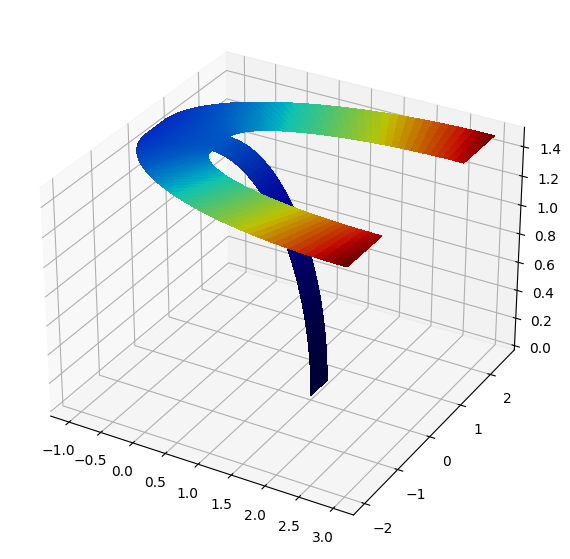

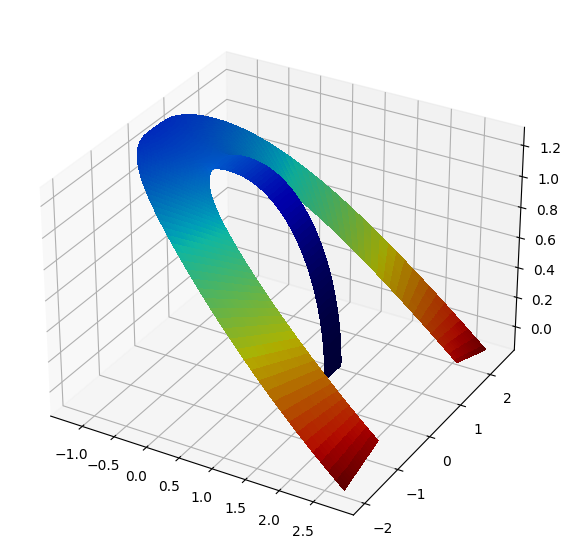

In [7]:
from matplotlib import cm
YS = np.meshgrid(np.linspace(-1,1,100), np.linspace(-1,1,100))



ys = np.concatenate((YS[0].flatten()[...,None]*0, YS[0].flatten()[...,None], YS[1].flatten()[...,None]),-1)
Xs1 = geom1(ys)
Us1 = model.solution1(weights, ys)
Z1 = np.linalg.norm(Us1,axis=-1).reshape(YS[0].shape)

ys = np.concatenate((YS[0].flatten()[...,None]*0, YS[0].flatten()[...,None], YS[1].flatten()[...,None]),-1)
Xs2 = geom2(ys)
Us2 = model.solution2(weights, ys)
Z2 = np.linalg.norm(Us2,axis=-1).reshape(YS[0].shape)

ys = np.concatenate((YS[0].flatten()[...,None]*0, YS[0].flatten()[...,None], YS[1].flatten()[...,None]),-1)
Xs3 = geom3(ys)
Us3 = model.solution3(weights, ys)
Z3 = np.linalg.norm(Us3,axis=-1).reshape(YS[0].shape)

ys = np.concatenate((YS[0].flatten()[...,None]*0, YS[0].flatten()[...,None], YS[1].flatten()[...,None]),-1)
Xs4 = geom4(ys)
Us4 = model.solution4(weights, ys)
Z4 = np.linalg.norm(Us4,axis=-1).reshape(YS[0].shape)

Zmax = max([np.amax(Z1), np.amax(Z2), np.amax(Z3), np.amax(Z4)])

plt.figure(figsize=(7,7))
ax = plt.axes(projection ="3d")
my_col = cm.jet(Z1/Zmax)
ax.plot_surface(Xs1[:,0].reshape(YS[0].shape), Xs1[:,1].reshape(YS[0].shape), Xs1[:,2].reshape(YS[0].shape),facecolors = my_col, linewidth=0, antialiased=False)

my_col = cm.jet(Z2/Zmax)
ax.plot_surface(Xs2[:,0].reshape(YS[0].shape), Xs2[:,1].reshape(YS[0].shape), Xs2[:,2].reshape(YS[0].shape),facecolors = my_col, linewidth=0, antialiased=False)

my_col = cm.jet(Z3/Zmax)
ax.plot_surface(Xs3[:,0].reshape(YS[0].shape), Xs3[:,1].reshape(YS[0].shape), Xs3[:,2].reshape(YS[0].shape),facecolors = my_col, linewidth=0, antialiased=False)

my_col = cm.jet(Z4/Zmax)
ax.plot_surface(Xs4[:,0].reshape(YS[0].shape), Xs4[:,1].reshape(YS[0].shape), Xs4[:,2].reshape(YS[0].shape),facecolors = my_col, linewidth=0, antialiased=False)


plt.figure(figsize=(7,7))
ax = plt.axes(projection ="3d")
my_col = cm.jet(Z1/Zmax)
ax.plot_surface((Xs1+Us1)[:,0].reshape(YS[0].shape), (Xs1+Us1)[:,1].reshape(YS[0].shape), (Xs1+Us1)[:,2].reshape(YS[0].shape),facecolors = my_col, linewidth=0, antialiased=False)

my_col = cm.jet(Z2/Zmax)
ax.plot_surface((Xs2+Us2)[:,0].reshape(YS[0].shape), (Xs2+Us2)[:,1].reshape(YS[0].shape), (Xs2+Us2)[:,2].reshape(YS[0].shape),facecolors = my_col, linewidth=0, antialiased=False)

my_col = cm.jet(Z3/Zmax)
ax.plot_surface((Xs3+Us3)[:,0].reshape(YS[0].shape), (Xs3+Us3)[:,1].reshape(YS[0].shape), (Xs3+Us3)[:,2].reshape(YS[0].shape),facecolors = my_col, linewidth=0, antialiased=False)

my_col = cm.jet(Z4/Zmax)
ax.plot_surface((Xs4+Us4)[:,0].reshape(YS[0].shape), (Xs4+Us4)[:,1].reshape(YS[0].shape), (Xs4+Us4)[:,2].reshape(YS[0].shape),facecolors = my_col, linewidth=0, antialiased=False)

# ys = np.concatenate((YS[0].flatten()[...,None], YS[0].flatten()[...,None]*0, YS[1].flatten()[...,None]),-1)
# Us = model.solution2(weights, ys)
# Us2 = Us
# ax.plot(Xs[:,0], Xs[:,1], Xs[:,2],'gray')
# ax.plot(Xs[:,0]+Us[:,0], Xs[:,1]+Us[:,1], Xs[:,2]+Us[:,2],'blue')
# 
# Xs = geom3(ys)
# Us = model.solution3(weights, ys)
# ax.plot(Xs[:,0], Xs[:,1], Xs[:,2],'gray')
# ax.plot(Xs[:,0]+Us[:,0], Xs[:,1]+Us[:,1], Xs[:,2]+Us[:,2],'blue')
# 
# Xs = geom4(ys)
# Us = model.solution4(weights, ys)
# ax.plot(Xs[:,0], Xs[:,1], Xs[:,2],'gray')
# #ax.plot(Xs[:,0]+Us[:,0], Xs[:,1]+Us[:,1], Xs[:,2]+Us[:,2],'blue')

Plot the deformation of the domains. The solutions and the geometry objects are JITed first.

In [8]:
solutions = [jax.jit(model.solution1, device = jax.devices('cpu')[0]), jax.jit(model.solution2, device = jax.devices('cpu')[0]), jax.jit(model.solution3, device = jax.devices('cpu')[0]), jax.jit(model.solution4, device = jax.devices('cpu')[0])]
geoms = [jax.jit(g, device = jax.devices('cpu')[0]) for g in geoms]

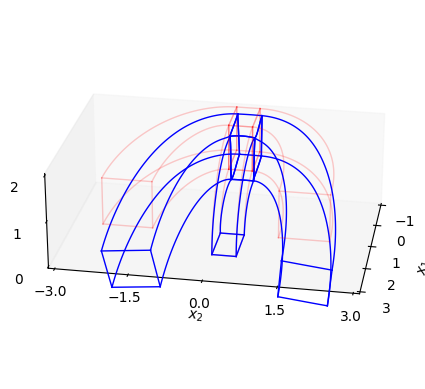

In [9]:
ys = jnp.linspace(-1,1,100)[...,None]
Ys  = [jnp.concatenate((ys,ys*0-1,ys*0-1), -1)]
Ys += [jnp.concatenate((ys,ys*0-1,ys*0+1), -1)]
Ys += [jnp.concatenate((ys,ys*0+1,ys*0-1), -1)]
Ys += [jnp.concatenate((ys,ys*0+1,ys*0+1), -1)]
Ys += [jnp.concatenate((ys*0-1,ys,ys*0-1), -1)]
Ys += [jnp.concatenate((ys*0-1,ys,ys*0+1), -1)]
Ys += [jnp.concatenate((ys*0+1,ys,ys*0-1), -1)]
Ys += [jnp.concatenate((ys*0+1,ys,ys*0+1), -1)]
Ys += [jnp.concatenate((ys*0-1,ys*0-1,ys), -1)]
Ys += [jnp.concatenate((ys*0-1,ys*0+1,ys), -1)]
Ys += [jnp.concatenate((ys*0+1,ys*0-1,ys), -1)]
Ys += [jnp.concatenate((ys*0+1,ys*0+1,ys), -1)]

plt.figure()
ax = plt.axes(projection ="3d")




for i in range(4):
    for k in range(12):
        Xs = geoms[i](Ys[k])
        Us = solutions[i](weights, Ys[k])
        ax.plot(Xs[:,0], Xs[:,1], Xs[:,2],'red',linewidth = 1,alpha=0.2)
        ax.plot(Xs[:,0]+Us[:,0], Xs[:,1]+Us[:,1], Xs[:,2]+Us[:,2],'blue',linewidth = 1)
      
ax.grid(False)  
ax.axes.set_xlim3d(-1,3)
ax.axes.set_ylim3d(-3,3)
ax.axes.set_zlim3d(0,2)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.set_zlabel(r'$x_3$')
ax.set_zticks([0,1,2])
ax.set_xticks([-1,0,1,2,3])
ax.set_yticks([-3,-1.5,0,1.5,3])
ax.view_init(25,10)
ax.set_box_aspect(aspect = (4,6,2))
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.savefig('./elasto_3d.pdf',bbox_inches='tight')



In [12]:
try:
    from elastostatics_3d_fem import FEM
    
    tme = datetime.datetime.now()
    fem = FEM(model.E, model.nu, model.rho)
    fem.solve(0.1/2, True)
    tme = datetime.datetime.now() - tme
    
    Nmc = 500000

    points = jax.jit(lambda : model.get_points_MC(Nmc, rnd_key), device = jax.devices('cpu')[0])()

    xs1 = geoms[0](points['ys1'])    
    xs2 = geoms[1](points['ys2'])    
    xs3 = geoms[2](points['ys3'])    
    xs4 = geoms[3](points['ys4'])    

    u1 = solutions[0](weights, points['ys1'])
    u2 = solutions[1](weights, points['ys2'])
    u3 = solutions[2](weights, points['ys3'])
    u4 = solutions[3](weights, points['ys4'])
    us = np.concatenate((u1,u2,u3,u4),0)

    u1_fem = fem(np.array(xs1))
    u2_fem = fem(np.array(xs2))
    u3_fem = fem(np.array(xs3))
    u4_fem = fem(np.array(xs4))
    us_fem = np.concatenate((u1_fem,u2_fem,u3_fem,u4_fem),0)

    ws = np.concatenate((points['ws1'],points['ws2'],points['ws3'],points['ws4']))
    omegas = np.concatenate((points['omega1'],points['omega2'],points['omega3'],points['omega4']))

    err2 = np.nansum(np.nansum((us-us_fem)**2,-1)*ws*omegas) / np.nansum(np.nansum((us_fem)**2,-1)*ws*omegas)
    err_max = np.nanmax(np.abs(us-us_fem)) / np.nanmax(np.abs(us_fem))

    print('Relative L2 %e\nRelative Linf %f %%\nTime %f s'%(err2,err_max*100, tme.total_seconds()))
except:
    print("FENICS not available.")

geo file created
Info    : Running '/home/yonnss/anaconda3/envs/fenics_jax/bin/gmsh ./tmp.geo -nt 20 -3 -o ./tmp.msh -format msh2' [Gmsh 4.11.0, 1 node, max. 20 threads]
Info    : Started on Thu Dec  8 14:16:23 2022
Info    : Reading './tmp.geo'...
Info    : Done reading './tmp.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 114 (Ellipse)
Info    : [  0%] Meshing curve 111 (Line)
Info    : [  0%] Meshing curve 108 (Line)
Info    : [  0%] Meshing curve 109 (Line)
Info    : [  0%] Meshing curve 116 (Line)
Info    : [  0%] Meshing curve 110 (Line)
Info    : [  0%] Meshing curve 104 (Line)
Info    : [  0%] Meshing curve 100 (Circle)
Info    : [  0%] Meshing curve 119 (Line)
Info    : [  0%] Meshing curve 112 (Ellipse)
Info    : [  0%] Meshing curve 103 (Circle)
Info    : [  0%] Meshing curve 113 (Ellipse)
Info    : [  0%] Meshing curve 117 (Line)
Info    : [  0%] Meshing curve 101 (Circle)
Info    : [  0%] Meshing curve 102 (Circle)
Info    : [  0%] Meshing curve 115 (Ellipse)


Info    : Done meshing 2D (Wall 0.204841s, CPU 1.99785s)
Info    : Meshing 3D...
Info    : 3D Meshing 4 volumes with 1 connected component
Info    : Tetrahedrizing 60810 nodes...
Info    : Done tetrahedrizing 60818 nodes (Wall 0.911182s, CPU 0.906698s)
Info    : Reconstructing mesh...
Info    :  - Creating surface mesh
Info    :  - Identifying boundary edges
Info    :  - Recovering boundary
Info    : Done reconstructing mesh (Wall 2.47887s, CPU 2.3848s)
Info    : Found volume 3
Info    : Found volume 4
Info    : Found volume 2
Info    : Found volume 1
Info    : It. 0 - 0 nodes created - worst tet radius 27.059 (nodes removed 0 0)
Info    : It. 500 - 500 nodes created - worst tet radius 6.45971 (nodes removed 0 0)
Info    : It. 1000 - 1000 nodes created - worst tet radius 5.28154 (nodes removed 0 0)
Info    : It. 1500 - 1500 nodes created - worst tet radius 4.67289 (nodes removed 0 0)
Info    : It. 2000 - 2000 nodes created - worst tet radius 4.30405 (nodes removed 0 0)
Info    : It. 25

Info    : It. 43500 - 43500 nodes created - worst tet radius 1.6663 (nodes removed 0 0)
Info    : It. 44000 - 44000 nodes created - worst tet radius 1.66017 (nodes removed 0 0)
Info    : It. 44500 - 44500 nodes created - worst tet radius 1.65435 (nodes removed 0 0)
Info    : It. 45000 - 45000 nodes created - worst tet radius 1.64835 (nodes removed 0 0)
Info    : It. 45500 - 45500 nodes created - worst tet radius 1.64241 (nodes removed 0 0)
Info    : It. 46000 - 46000 nodes created - worst tet radius 1.63671 (nodes removed 0 0)
Info    : It. 46500 - 46500 nodes created - worst tet radius 1.63106 (nodes removed 0 0)
Info    : It. 47000 - 47000 nodes created - worst tet radius 1.62538 (nodes removed 0 0)
Info    : It. 47500 - 47500 nodes created - worst tet radius 1.62009 (nodes removed 0 0)
Info    : It. 48000 - 48000 nodes created - worst tet radius 1.61483 (nodes removed 0 0)
Info    : It. 48500 - 48500 nodes created - worst tet radius 1.6097 (nodes removed 0 0)
Info    : It. 49000 - 4

Info    : It. 92500 - 92500 nodes created - worst tet radius 1.31215 (nodes removed 0 0)
Info    : It. 93000 - 93000 nodes created - worst tet radius 1.30983 (nodes removed 0 0)
Info    : It. 93500 - 93500 nodes created - worst tet radius 1.30755 (nodes removed 0 0)
Info    : It. 94000 - 94000 nodes created - worst tet radius 1.30545 (nodes removed 0 0)
Info    : It. 94500 - 94500 nodes created - worst tet radius 1.30314 (nodes removed 0 0)
Info    : It. 95000 - 95000 nodes created - worst tet radius 1.30094 (nodes removed 0 0)
Info    : It. 95500 - 95500 nodes created - worst tet radius 1.29885 (nodes removed 0 0)
Info    : It. 96000 - 96000 nodes created - worst tet radius 1.29674 (nodes removed 0 0)
Info    : It. 96500 - 96500 nodes created - worst tet radius 1.29456 (nodes removed 0 0)
Info    : It. 97000 - 97000 nodes created - worst tet radius 1.29234 (nodes removed 0 0)
Info    : It. 97500 - 97500 nodes created - worst tet radius 1.29026 (nodes removed 0 0)
Info    : It. 98000 -

Info    : It. 140000 - 140000 nodes created - worst tet radius 1.14984 (nodes removed 0 0)
Info    : It. 140500 - 140500 nodes created - worst tet radius 1.14847 (nodes removed 0 0)
Info    : It. 141000 - 141000 nodes created - worst tet radius 1.1472 (nodes removed 0 0)
Info    : It. 141500 - 141500 nodes created - worst tet radius 1.1459 (nodes removed 0 0)
Info    : It. 142000 - 142000 nodes created - worst tet radius 1.14457 (nodes removed 0 0)
Info    : It. 142500 - 142500 nodes created - worst tet radius 1.14332 (nodes removed 0 0)
Info    : It. 143000 - 143000 nodes created - worst tet radius 1.14203 (nodes removed 0 0)
Info    : It. 143500 - 143500 nodes created - worst tet radius 1.14074 (nodes removed 0 0)
Info    : It. 144000 - 144000 nodes created - worst tet radius 1.13954 (nodes removed 0 0)
Info    : It. 144500 - 144500 nodes created - worst tet radius 1.13826 (nodes removed 0 0)
Info    : It. 145000 - 145000 nodes created - worst tet radius 1.13703 (nodes removed 0 0)
I

Info    : It. 187500 - 187500 nodes created - worst tet radius 1.04738 (nodes removed 0 0)
Info    : It. 188000 - 188000 nodes created - worst tet radius 1.04644 (nodes removed 0 0)
Info    : It. 188500 - 188500 nodes created - worst tet radius 1.04553 (nodes removed 0 0)
Info    : It. 189000 - 189000 nodes created - worst tet radius 1.04467 (nodes removed 0 0)
Info    : It. 189500 - 189500 nodes created - worst tet radius 1.04377 (nodes removed 0 0)
Info    : It. 190000 - 190000 nodes created - worst tet radius 1.04289 (nodes removed 0 0)
Info    : It. 190500 - 190500 nodes created - worst tet radius 1.04204 (nodes removed 0 0)
Info    : It. 191000 - 191000 nodes created - worst tet radius 1.04122 (nodes removed 0 0)
Info    : It. 191500 - 191500 nodes created - worst tet radius 1.04032 (nodes removed 0 0)
Info    : It. 192000 - 192000 nodes created - worst tet radius 1.03944 (nodes removed 0 0)
Info    : It. 192500 - 192500 nodes created - worst tet radius 1.03862 (nodes removed 0 0)

Info    : Optimization starts (volume = 3.9268) with worst = 0.00196814 / average = 0.779739:
Info    : 0.00 < quality < 0.10 :       802 elements
Info    : 0.10 < quality < 0.20 :      2217 elements
Info    : 0.20 < quality < 0.30 :      4010 elements
Info    : 0.30 < quality < 0.40 :      6171 elements
Info    : 0.40 < quality < 0.50 :      9832 elements
Info    : 0.50 < quality < 0.60 :     16607 elements
Info    : 0.60 < quality < 0.70 :     35327 elements
Info    : 0.70 < quality < 0.80 :     81423 elements
Info    : 0.80 < quality < 0.90 :    132988 elements
Info    : 0.90 < quality < 1.00 :     67367 elements
Info    : 6950 edge swaps, 193 node relocations (volume = 3.9268): worst = 0.0819826 / average = 0.792033 (Wall 0.339214s, CPU 0.338533s)
Info    : 6995 edge swaps, 195 node relocations (volume = 3.9268): worst = 0.203078 / average = 0.792088 (Wall 0.43919s, CPU 0.438275s)
Info    : No ill-shaped tets in the mesh :-)
Info    : 0.00 < quality < 0.10 :         0 elements
Info

8148